In [322]:
import datetime
import tensorflow_datasets as tfds 
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, AveragePooling2D, Reshape, GlobalAveragePooling2D, Conv2DTranspose, MaxPooling2D



In [323]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [324]:
# PREPARE THE DATA
def preprocess(data):
    batch_size = 32

    #data = data.map(lambda image, target: (tf.expand_dims(image, axis=-1), target))
    data = data.map(lambda image, target: (image))
    data = data.map(lambda image: tf.cast(image, tf.float32))
    zip_data = tf.data.Dataset.zip(data.map(lambda image:(image+tf.random.normal(shape=(28,28,1), mean=0., stddev=40.), image)))

    data = zip_data.map(lambda image, target: ((tf.clip_by_value((image/128. -1),-1,1), (target/128. -1))))
    

    data.cache()
    data = data.shuffle(2000)
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data

In [325]:
def show_pic_or_didnt_happen(ds):
    # visualize data by plotting images
    for img, target in ds:
        print(img.shape, target.shape)
        plt.imshow(img[0])       
        plt.show()

        plt.imshow(target[0])       
        plt.show()
        break    

In [326]:
def visualize(img, target):
    plt.imshow(img[0])       
    plt.show()

    plt.imshow(target[0])       
    plt.show()


(32, 28, 28, 1) (32, 28, 28, 1)


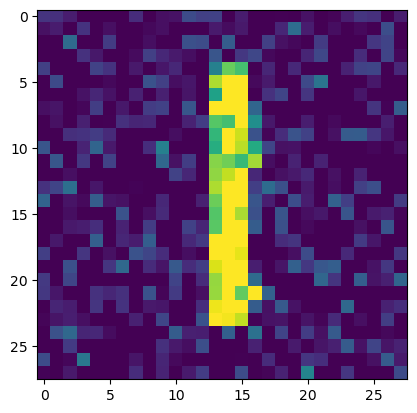

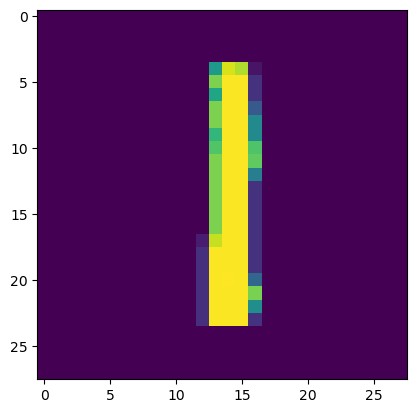

2023-01-01 18:01:48.156019: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [327]:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

show_pic_or_didnt_happen(train_ds)

# Encoder


In [328]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super().__init__()
    # input conv1 = 28x28x1
    self.conv1 = Conv2D(12, 3, activation='relu', padding='same')
    # output conv1 = 28x28x12
    self.conv2 = Conv2D(12, 3, activation='relu', padding='same')
    # output conv2 = 28x28x12
    self.pooling1 = MaxPooling2D()
    # output pooling1 = 14x14x12
    self.conv3 = Conv2D(24, 3, activation='relu', padding='same')
    # output conv3 = 14x14x24
    self.conv4 = Conv2D(24, 3, activation='relu', padding='same')    
    # output conv3 = 14x14x24

    self.pooling2 = MaxPooling2D()
    # output pooling1 = 7x7x24
    self.conv5 = Conv2D(48, 3, activation='relu', padding='same')
    # output conv3 = 7x7x48
    self.conv6 = Conv2D(48, 3, activation='relu', padding='same')
    # output conv3 = 7x7x48
    self.globalpooling = GlobalAveragePooling2D()
    # output global pool 48
    self.out = Dense(24, activation="sigmoid")


  @tf.function
  def __call__(self, x, training=False):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.pooling1(x)
    x = self.conv3(x)
    x = self.conv4(x)    
    x = self.pooling2(x)
    x = self.conv5(x)
    x = self.conv6(x)

    x = self.globalpooling(x)
    x = self.out(x)
    return x

In [329]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.dense = Dense(196, activation="elu")
        self.reshape = Reshape((7, 7, 4))
        self.convT1 = Conv2DTranspose(4, (3, 3), strides=2, activation="elu", padding="same")
        self.convT2 = Conv2DTranspose(2, (3, 3), strides=2, activation="elu", padding="same")
        self.conv = Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same")

    @tf.function
    def __call__(self, x, training=False):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.conv(x)

        return x

In [330]:
class Autoencoder(tf.keras.Model):
    def __init__(self, optimizer, loss_function):
        super().__init__()
        
        # input conv1 = 28x28x1
        self.conv1 = Conv2D(12, 3, activation='relu', padding='same')
        # output conv1 = 28x28x12
        self.conv2 = Conv2D(12, 3, activation='relu', padding='same')
        # output conv2 = 28x28x12
        self.pooling1 = MaxPooling2D()
        # output pooling1 = 14x14x12
        self.conv3 = Conv2D(24, 3, activation='relu', padding='same')
        # output conv3 = 14x14x24
        self.conv4 = Conv2D(24, 3, activation='relu', padding='same')    
        # output conv3 = 14x14x24

        self.pooling2 = MaxPooling2D()
        # output pooling1 = 7x7x24
        self.conv5 = Conv2D(48, 3, activation='relu', padding='same')
        # output conv3 = 7x7x48
        self.conv6 = Conv2D(48, 3, activation='relu', padding='same')
        # output conv3 = 7x7x48
        self.globalpooling = GlobalAveragePooling2D()
        # output global pool 48
        self.out = Dense(24, activation="sigmoid")

        self.dense = Dense(196, activation="elu")
        self.reshape = Reshape((7, 7, 4))
        self.convT1 = Conv2DTranspose(4, (3, 3), strides=2, activation="elu", padding="same")
        self.convT2 = Conv2DTranspose(2, (3, 3), strides=2, activation="elu", padding="same")
        self.conv = Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same")

        self.metrics_list = [
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Mean(name="loss")]

        self.optimizer = optimizer
        self.loss_function = loss_function


    def __call__(self, x, training=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pooling1(x)
        x = self.conv3(x)
        x = self.conv4(x)    
        x = self.pooling2(x)
        x = self.conv5(x)
        x = self.conv6(x)

        x = self.globalpooling(x)
        x = self.out(x)

        x = self.dense(x)
        x = self.reshape(x)
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.conv(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list
        
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()


    def train_step(self, data):
        image, label = data

        with tf.GradientTape() as tape: 
            prediction = self(image, training = True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)  

    
    def test_step(self, data):
        image, label = data
        prediction = self(image, training = False)
        loss = self.loss_function(label, prediction)
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)

        return label, prediction

In [331]:
class OverallModel(tf.keras.Model):
  def __init__(self, enc, dec, optimizer, loss_function):
    super().__init__()

    self.enc = enc
    self.dec = dec

    self.metrics_list = [
      tf.keras.metrics.BinaryAccuracy(name="accuracy"),
      tf.keras.metrics.Mean(name="loss")]

    self.optimizer = optimizer
    self.loss_function = loss_function

  @property
  def metrics(self):
    return self.metrics_list
    
  def reset_metrics(self):
     for metric in self.metrics:
        metric.reset_state()

  def call(self, input, training = False):
    latent_rep = self.enc(input)
    output = self.dec(latent_rep)
    return output

  def training_step(self, image, label):
    print("ja")
    print(label)
    with tf.GradientTape() as tape: 
      prediction = self(image, training = True)
      loss = self.loss_function(label, prediction)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
    self.metrics[0].update_state(label, prediction)
    self.metrics[1].update_state(loss)  

  def test_step(self, data):
    image, label = data
    prediction = self(image, training = False)
    loss = self.loss_function(label, prediction)
    self.metrics[0].update_state(label, prediction)
    self.metrics[1].update_state(loss)

    return label, prediction

In [332]:
#Training LOOp
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0, leave=True):
            model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        for data in tqdm(test_ds, position=0, leave=True):
            label, prediction = model.test_step(data)

        visualize(prediction, label)

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)

        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Test)")




    
    model.save_weights(save_path)

100%|██████████| 1875/1875 [01:46<00:00, 17.57it/s]


Epoch:  1
Loss:  -14.032167 Accuracy:  0.0015855655 (Train)


100%|██████████| 1875/1875 [00:32<00:00, 58.22it/s]


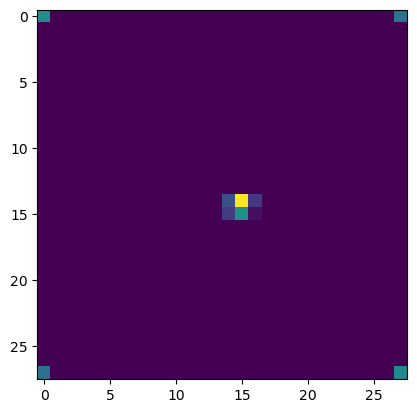

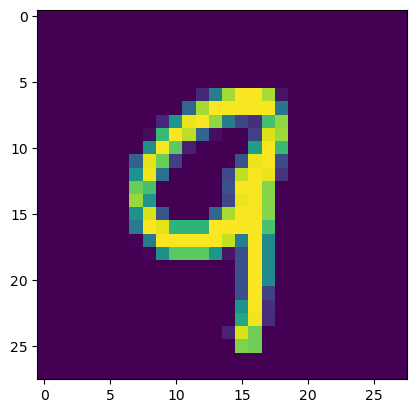

Loss:  -26.779758 Accuracy:  0.0015932398 (Test)


100%|██████████| 1875/1875 [01:44<00:00, 17.93it/s]


Epoch:  2
Loss:  -39.205814 Accuracy:  0.0015932185 (Train)


100%|██████████| 1875/1875 [00:30<00:00, 61.13it/s]


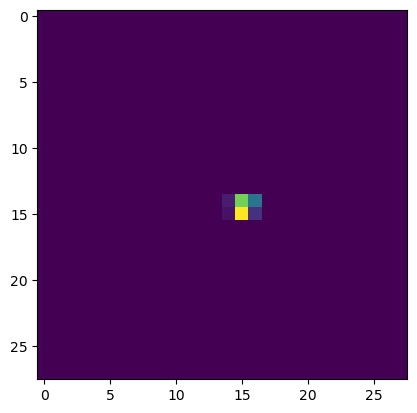

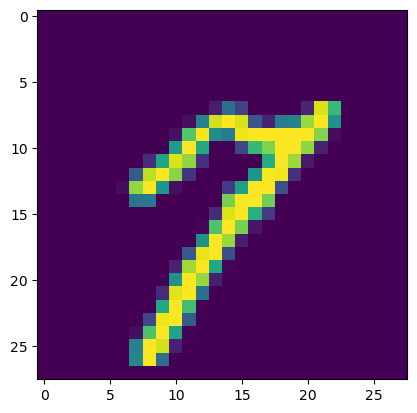

Loss:  -51.621532 Accuracy:  0.0015932398 (Test)


100%|██████████| 1875/1875 [01:46<00:00, 17.67it/s]


Epoch:  3
Loss:  -64.00655 Accuracy:  0.0015931336 (Train)


100%|██████████| 1875/1875 [00:30<00:00, 62.23it/s] 


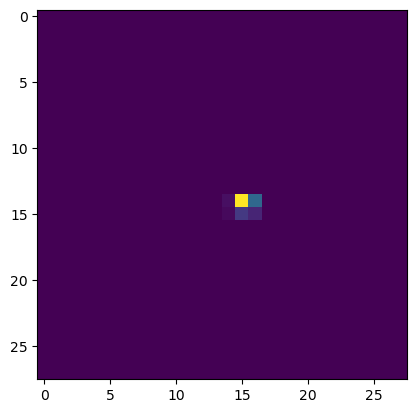

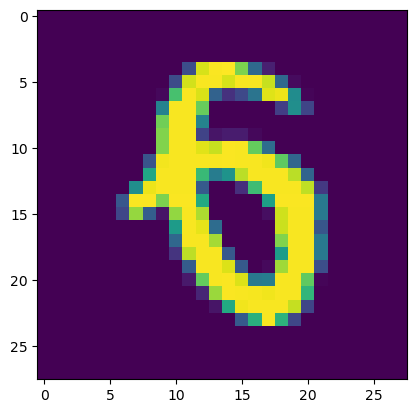

Loss:  -76.403336 Accuracy:  0.0015932398 (Test)


100%|██████████| 1875/1875 [01:36<00:00, 19.43it/s]


Epoch:  4
Loss:  -88.78376 Accuracy:  0.0015928359 (Train)


100%|██████████| 1875/1875 [00:16<00:00, 114.25it/s]


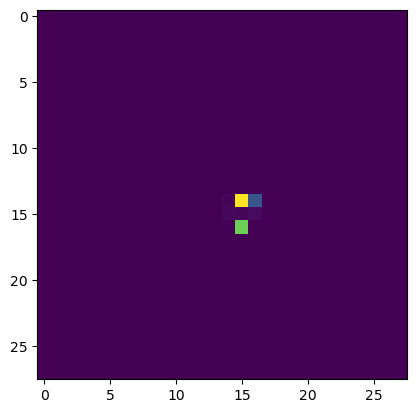

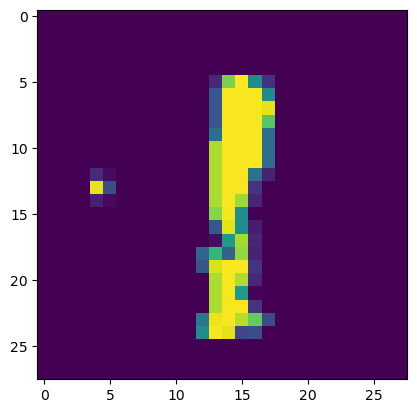

Loss:  -101.17679 Accuracy:  0.0015932398 (Test)


100%|██████████| 1875/1875 [01:04<00:00, 29.27it/s]


Epoch:  5
Loss:  -113.55702 Accuracy:  0.0015928572 (Train)


100%|██████████| 1875/1875 [00:16<00:00, 115.36it/s]


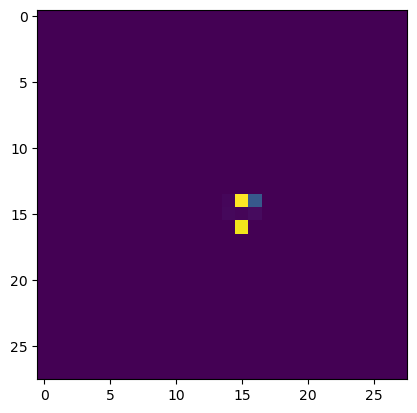

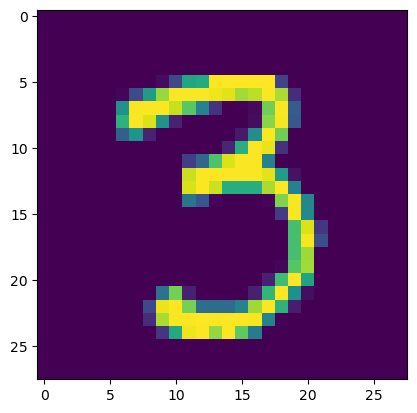

Loss:  -125.949615 Accuracy:  0.0015932398 (Test)


100%|██████████| 1875/1875 [01:03<00:00, 29.48it/s]


Epoch:  6
Loss:  -138.32874 Accuracy:  0.0015931336 (Train)


100%|██████████| 1875/1875 [00:16<00:00, 116.21it/s]


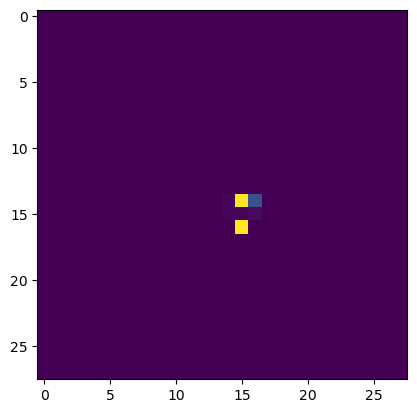

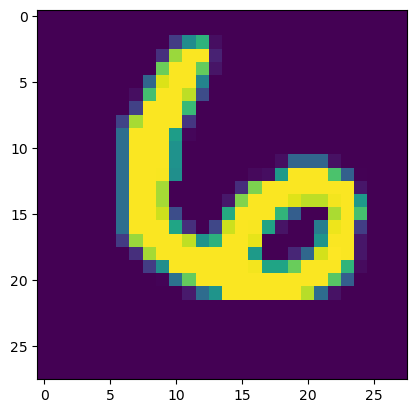

Loss:  -150.72176 Accuracy:  0.0015932398 (Test)


100%|██████████| 1875/1875 [01:03<00:00, 29.42it/s]


Epoch:  7
Loss:  -163.09973 Accuracy:  0.0015929635 (Train)


100%|██████████| 1875/1875 [00:16<00:00, 116.14it/s]


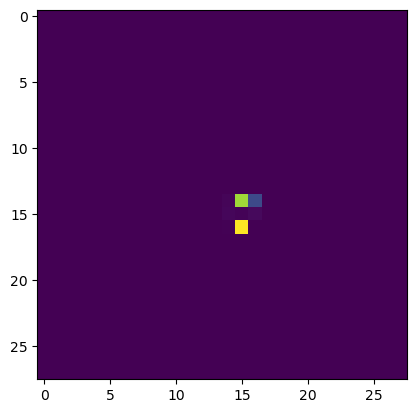

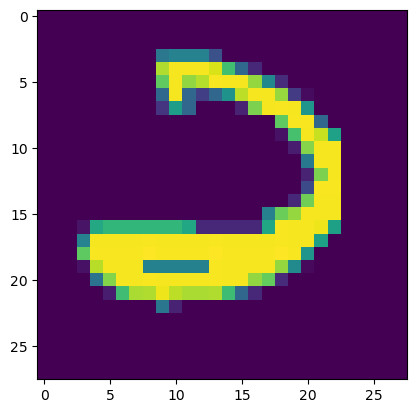

Loss:  -175.4936 Accuracy:  0.0015932398 (Test)


100%|██████████| 1875/1875 [01:03<00:00, 29.33it/s]


Epoch:  8
Loss:  -187.87149 Accuracy:  0.0015927721 (Train)


100%|██████████| 1875/1875 [00:16<00:00, 116.80it/s]


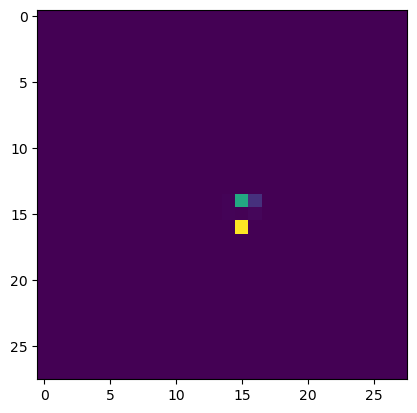

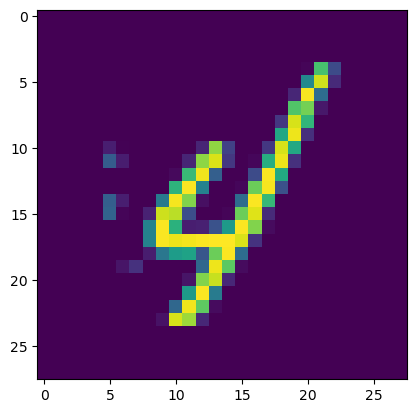

Loss:  -200.26357 Accuracy:  0.0015932398 (Test)


100%|██████████| 1875/1875 [01:03<00:00, 29.32it/s]


Epoch:  9
Loss:  -212.6431 Accuracy:  0.0015927934 (Train)


100%|██████████| 1875/1875 [00:16<00:00, 117.04it/s]


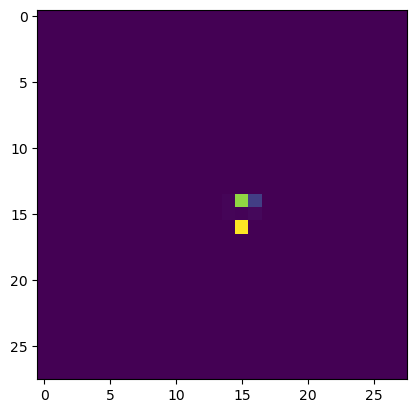

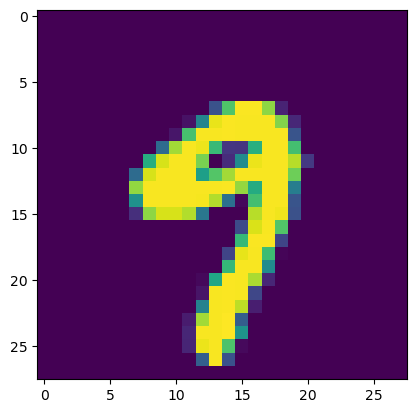

Loss:  -225.03511 Accuracy:  0.0015932398 (Test)


100%|██████████| 1875/1875 [01:04<00:00, 29.26it/s]


Epoch:  10
Loss:  -237.41489 Accuracy:  0.0015927721 (Train)


100%|██████████| 1875/1875 [00:15<00:00, 118.04it/s]


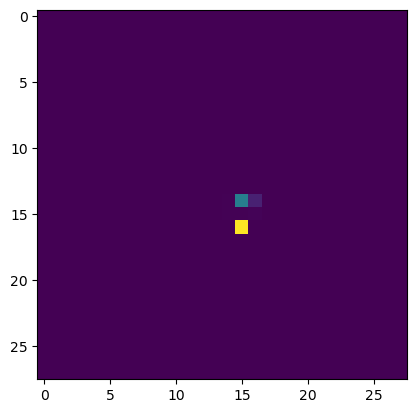

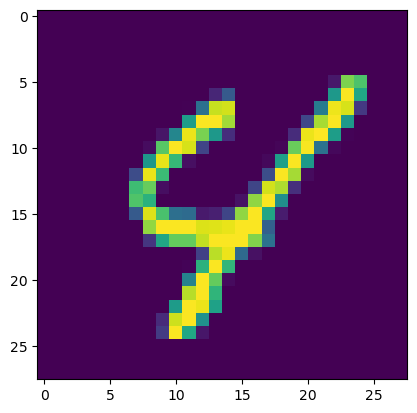

Loss:  -249.80463 Accuracy:  0.0015932398 (Test)


In [333]:
batch_size = 32
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.BinaryCrossentropy()
enc = Encoder()
dec = Decoder()

model = OverallModel(enc=enc, dec=dec, optimizer=optimizer, loss_function=loss_function)
epochs = 10

autoencoder = Autoencoder(optimizer=optimizer, loss_function=loss_function)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(autoencoder, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

In [334]:
%tensorboard --logdir logs